In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

'1.10.0'

In [ ]:
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import math
import os.path
import os
import csv
import glob
import h5py as h5py
import imageio
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as img
import dlib
import shutil
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from mlxtend.image import extract_face_landmarks
from imutils import face_utils
from threading import Thread
from scipy.spatial import distance 
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from IPython.display import clear_output
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

# Feature Extraction

In [ ]:
def eye_aspect_ratio(eye):
   # calculating ratio of length and width of eyes
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [ ]:
def mouth_aspect_ratio(mouth):
    #calculating ratio of length and width of mouth
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

In [ ]:
def circularity(eye):
    """Calculates PUC -> low perimeter leads to lower pupil"""
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area / (p**2)

In [ ]:
def mouth_over_eye(eye):
    #calculating ratio of MAR to EAR
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

In [ ]:
# Code for the extraction referred from https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481
def frame_extraction(folder = "Fold5_part2", participants = [55, 60], MAX_FRAMES = 240):
    def captureFrame(sec):
        # setting the starting time at 3 minutes
        start = 180000
        #setting the timestamp to get the frame at that particular second
        vidcap.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
        #gets the frame from the specified second
        ret_frame, image = vidcap.read()
        
        if ret_frame:
            #if there is no existing  folder
            if not (os.path.exists(r"D:\\Downloads\\img\\" + str(parti_num) + "\\")):
                #making new folder
                os.mkdir(r"D:\\Downloads\\img\\" + str(parti_num))
            #saving the frame
            cv2.imwrite(r"D:\\Downloads\\img\\" + str(parti_num) + "\\p" + str(parti_num) + "_s" + str(state) +
                        "_" + str(frame_count) + "sec.jpg", image)    
        return ret_frame, image

    
    
    parti_num, state = 0, 0
    # Loop through all videos in a specific folder. Best results with .mov files.
    for j in participants:
        for i in np.arange(0, 11, 5):
            #clearing the output at every frame otherwise it will create flickering
            clear_output(wait=True)
            print(f'Starting with participant {j} and state {i}')
            values = []
            labels = []
            #reading the video
            vidcap = cv2.VideoCapture(r'D:\\Downloads\\' + str(folder) + '\\' + str(j) +'\\' + str(i) + '.mov')
            # printing the number of frames in the video
            print(f"Total Frames in selected Video {int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))}")
            sec = 0
            frameRate = 1
            frame_count = 0
            acquire_frame, image  = captureFrame(sec)
            parti_num = j
            state = i
            # Extract frames (per video), the more frames the longer the extraction takes
            while acquire_frame and frame_count < MAX_FRAMES: 
                # function from mlxtend library to extract detect and extract face shape
                landmarks = extract_face_landmarks(image)
                if landmarks is not None and sum(sum(landmarks)) != 0:
    
                    frame_count += 1
                    values.append(landmarks)
                    labels.append([i])
                    #adding framerate to get the next frame
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    #capture next frame
                    acquire_frame, image = captureFrame(sec)
                    print(frame_count)
                else:  
                    #if face not detected
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    acquire_frame, image = captureFrame(sec)
                    print("not detected")
            if acquire_frame:
                values = np.array(values)
                labels = np.array(labels)
                print(f"Data {values.shape}")
                print(f"Labels {labels.shape}")
                interested_features = []
                # eye and mouth feature extraction referred from https://github.com/sandyying/APM-Drowsiness-Detection/blob/master/Feature%20Extraction.ipynb
                for k in values:
                    # extracting only the interested features i.e., eye and mouth
                    key_landmark = k[36:68]
                    # here we create our features for our base classifier
                    ear = eye_aspect_ratio(key_landmark)
                    mar = mouth_aspect_ratio(key_landmark)
                    cir = circularity(key_landmark)
                    mouth_eye = mouth_over_eye(key_landmark)
                    interested_features.append([int(parti_num), ear, mar, cir, mouth_eye])
                interested_features = np.array(interested_features)
                print(f"Features {interested_features.shape}")
                # saving captured features in csv
                np.savetxt('D:\\Downloads\\data_drowsiness\\' + str(folder) +'_features_'+str(parti_num)+'_'+str(state)+'.csv', interested_features, delimiter = ",")
                np.savetxt('D:\\Downloads\\data_drowsiness\\' + str(folder) +'_labels_'+str(parti_num)+'_'+str(state)+'.csv', labels, delimiter = ",")

In [ ]:

%%time
#to load the videos
x = os.listdir('D:\\Downloads\\')
for i,j in zip(x, [os.listdir('D:\\Downloads\\'+i) for i in x]):
    frame_extraction(folder=i, participants=j)



Starting with participant Fold1_part2_features_10_10.csv and state 10


KeyboardInterrupt: 

In [ ]:
pd.read_csv(r"D:\\Downloads\\data_drowsiness\Fold1_part1_features_1_5.csv", header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"])

,Participant,EAR,MAR,Circularity,MOE
0,1.0,0.306011,0.850631,0.439164,2.779737
1,1.0,0.300157,0.883182,0.430257,2.942402
2,1.0,0.318335,0.875474,0.466570,2.750171
3,1.0,0.302996,0.887505,0.454279,2.929104
4,1.0,0.340870,0.890336,0.496024,2.611952
...,...,...,...,...,...
235,1.0,0.309938,0.816165,0.432415,2.633318
236,1.0,0.298477,0.787879,0.436982,2.639667
237,1.0,0.260300,0.841359,0.421348,3.232268
238,1.0,0.299461,0.810135,0.419005,2.705307


In [ ]:
# reading all the features and labels and combining them together
df_features = [pd.read_csv(f, header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"]) for f in glob.glob("D:\\Downloads\\data_drowsiness\Fold*_features_*.csv")]
df_labels = [pd.read_csv(f, header=None, names=["Y"]) for f in glob.glob("D:\\Downloads\\data_drowsiness\Fold*_labels_*.csv")]

df = pd.concat([pd.concat(df_features,ignore_index=True), pd.concat(df_labels,ignore_index=True)], axis=1)
print(df.shape) 
# Save merged file


(18480, 6)


In [ ]:
df.to_csv(r'D:\\Downloads\\data_drowsiness\merged\combined_feature_label.csv',index=False)
df.head()

,Participant,EAR,MAR,Circularity,MOE,Y
0,1.0,0.312688,0.792397,0.432896,2.534145,0.0
1,1.0,0.321940,0.766199,0.486923,2.379947,0.0
2,1.0,0.331216,0.688449,0.456029,2.078550,0.0
3,1.0,0.309246,0.776136,0.452655,2.509767,0.0
4,1.0,0.204691,0.734189,0.361123,3.586821,0.0


# Standardization

In [ ]:
df_combined = pd.read_csv(r'D:\\Downloads\\data_drowsiness\\merged\\combined_feature_label.csv')

In [ ]:


# we have to rearrange the columns
column = df_combined.columns.tolist()
column = column[-1:] + column[4:5] + column[:4]
df_combined = df_combined[column]
df_combined

,Y,MOE,Participant,EAR,MAR,Circularity
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123
...,...,...,...,...,...,...
18475,5.0,3.011821,60.0,0.348480,1.049561,0.490477
18476,5.0,4.016572,60.0,0.262352,1.053755,0.395392
18477,5.0,3.212684,60.0,0.319431,1.026230,0.490811
18478,5.0,4.230846,60.0,0.256146,1.083715,0.378786


In [ ]:
df_combined.isna().sum()

Y              0
MOE            0
Participant    0
EAR            0
MAR            0
Circularity    0
dtype: int64

In [ ]:
df_combined.duplicated().sum()

13

In [ ]:
#Removing the duplicate values

t = df_combined.drop_duplicates("Participant")
df_combined = df_combined[~df_combined.Participant.isin(t[t.Y > 0].Participant)]
df_combined.shape


(17280, 6)

In [ ]:

class Standardization:
    
    def __init__(self, df_combined):
        self.df_combined = df_combined

    #Functions for getting mean and std of each feature
    def calculate_Standardization(self):
        def mean_EAR(respondent):
            return df_means.loc[respondent]["EAR"]

        def mean_MAR(respondent):
            return df_means.loc[respondent]["MAR"]

        def mean_Circularity(respondent):
            return df_means.loc[respondent]["Circularity"]

        def mean_MOE(respondent):
            return df_means.loc[respondent]["MOE"]

        def std_EAR(respondent):
            return df_std.loc[respondent]["EAR"]

        def std_MAR(respondent):
            return df_std.loc[respondent]["MAR"]

        def std_Circularity(respondent):
            return df_std.loc[respondent]["Circularity"]

        def std_MOE(respondent):
            return df_std.loc[respondent]["MOE"]
        
       #Separating the rows which are "Alert" only
        df_state = self.df_combined[self.df_combined["Y"] == 0] 
        
        #Creating separate dataframes for each participants "Alert" state
        df_state_1 = df_state.iloc[0::240, :]
        df_state_2 = df_state.iloc[1::240, :]
        df_state_3 = df_state.iloc[2::240, :]
        
        #combining all "Alert" state into one dataframe
        state_first3 = [df_state_1,df_state_2,df_state_3]
        df_state_first3 = pd.concat(state_first3)
        df_state_first3 = df_state_first3.sort_index()
        
        # calculating per participant the mean and std for each feature
        pd.options.mode.chained_assignment = None
        df_means = df_state_first3.groupby("Participant")[["EAR", "MAR", "Circularity", "MOE"]].mean()
        df_std = df_state_first3.groupby("Participant")[["EAR", "MAR", "Circularity", "MOE"]].std()
        
        #Adding participant wise mean and std for each feature to each row in the original dataframe
        self.df_combined["EAR_mean"] = self.df_combined["Participant"].apply(mean_EAR)
        self.df_combined["MAR_mean"] = self.df_combined["Participant"].apply(mean_MAR)
        self.df_combined["Circularity_mean"] = self.df_combined["Participant"].apply(mean_Circularity)
        self.df_combined["MOE_mean"] = self.df_combined["Participant"].apply(mean_MOE)

        self.df_combined["EAR_std"] = self.df_combined["Participant"].apply(std_EAR)
        self.df_combined["MAR_std"] = self.df_combined["Participant"].apply(std_MAR)
        self.df_combined["Circularity_std"] = self.df_combined["Participant"].apply(std_Circularity)
        self.df_combined["MOE_std"] = self.df_combined["Participant"].apply(std_MOE)
        self.df_combined.head()
        print(self.df_combined.shape)
        
        #Normalizing the values
        self.df_combined["EAR_N"] = (self.df_combined["EAR"] - self.df_combined["EAR_mean"]) / self.df_combined["EAR_std"]
        self.df_combined["MAR_N"] = (self.df_combined["MAR"] - self.df_combined["MAR_mean"]) / self.df_combined["MAR_std"]
        self.df_combined["Circularity_N"] = (self.df_combined["Circularity"] - self.df_combined["Circularity_mean"]) / self.df_combined["Circularity_std"]
        self.df_combined["MOE_N"] = (self.df_combined["MOE"] - self.df_combined["MOE_mean"]) / self.df_combined["MOE_std"]
        return self.df_combined

### Performing standardization

In [ ]:

pd.options.mode.chained_assignment = None

# Standardization
df_combined = Standardization(df_combined).calculate_Standardization()
df_combined.head()

(17280, 14)


,Y,MOE,Participant,EAR,MAR,Circularity,EAR_mean,MAR_mean,Circularity_mean,MOE_mean,EAR_std,MAR_std,Circularity_std,MOE_std,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-12.657205,-0.274242,-3.596686,5.419921


In [ ]:
# Saving the file to a CSV with all the information
df_combined.to_csv(r'D:\\Downloads\\data_drowsiness\prepared\whole_info.csv',index=False)

# Saving the file to a CSV with all the information
df_main = df_combined.drop(["EAR_mean","MAR_mean", "Circularity_mean", "MOE_mean", "EAR_std", "MAR_std", "Circularity_std", "MOE_std"], axis=1)
df_main.to_csv(r'D:\\Downloads\\data_drowsiness\prepared\normalized_data.csv',index=False)

## KNN

In [1]:
# import all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# read the dataset 
df = pd.read_csv('totalwithmaininfo.csv',sep=',')
df.head()

,Y,MOE,Participant,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921


In [3]:
df

,Y,MOE,Participant,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...,...
17275,5.0,3.011821,60.0,0.348480,1.049561,0.490477,0.219129,1.045407,0.011833,0.117043
17276,5.0,4.016572,60.0,0.262352,1.053755,0.395392,-3.791320,1.211484,-2.815814,4.557594
17277,5.0,3.212684,60.0,0.319431,1.026230,0.490811,-1.133518,0.121610,0.021755,1.004766
17278,5.0,4.230846,60.0,0.256146,1.083715,0.378786,-4.080274,2.397807,-3.309649,5.504590


In [4]:
# let's check what all unique value do we have in the "Participant" column
df['Participant'].unique()

array([ 1.,  2.,  3.,  5., 10., 16., 18., 19., 21., 22., 27., 28., 34.,
       37., 43., 44., 48., 50., 51., 52., 53., 56., 57., 59., 60.])

In [5]:
# let's check what all unique value do we have in the "Y" column
df['Y'].unique()

array([ 0., 10.,  5.])

In [6]:
# let's drop the Participant column as we do not need this
df.drop(["Participant"], axis=1, inplace = True)

In [7]:
# We will drop all the rows where Y == 5 because we are not considering the states with "low vigilant state"
df.drop(df[df.Y == 5].index, inplace=True)

In [8]:
df

,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
17035,10.0,4.791645,0.213104,1.021117,0.367879,-6.084482,-0.080850,-3.634001,7.983071
17036,10.0,4.072009,0.244625,0.996117,0.445070,-4.616718,-1.070763,-1.338495,4.802602
17037,10.0,3.644583,0.286575,1.044448,0.425488,-2.663385,0.842954,-1.920805,2.913568
17038,10.0,3.840868,0.265593,1.020106,0.414632,-3.640416,-0.120886,-2.243641,3.781062


In [9]:
# Set 0.0 of y to int(0) which is set it to awake class
# Set 10.0 of y to int(1) which is set it to drowsy class
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

In [10]:
# let's print the dataset
df

,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
17035,1.0,4.791645,0.213104,1.021117,0.367879,-6.084482,-0.080850,-3.634001,7.983071
17036,1.0,4.072009,0.244625,0.996117,0.445070,-4.616718,-1.070763,-1.338495,4.802602
17037,1.0,3.644583,0.286575,1.044448,0.425488,-2.663385,0.842954,-1.920805,2.913568
17038,1.0,3.840868,0.265593,1.020106,0.414632,-3.640416,-0.120886,-2.243641,3.781062


In [11]:
# X will have all the columns apart from the Y
X = df.drop('Y',axis=1).values
y = df['Y'].values

In [12]:
# let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [13]:
# import KNeighbours
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# let's start with K=1
knn = KNeighborsClassifier(n_neighbors=1)

In [15]:
# Now we will fit the model.
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [16]:
# evaluation and prediction
pred = knn.predict(X_test)

In [17]:
# let's evaluate our KNN model
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
print(confusion_matrix(y_test,pred))

[[976 249]
 [194 933]]


In [19]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82      1225
         1.0       0.79      0.83      0.81      1127

    accuracy                           0.81      2352
   macro avg       0.81      0.81      0.81      2352
weighted avg       0.81      0.81      0.81      2352



In [20]:
# now let's choose a value for K
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

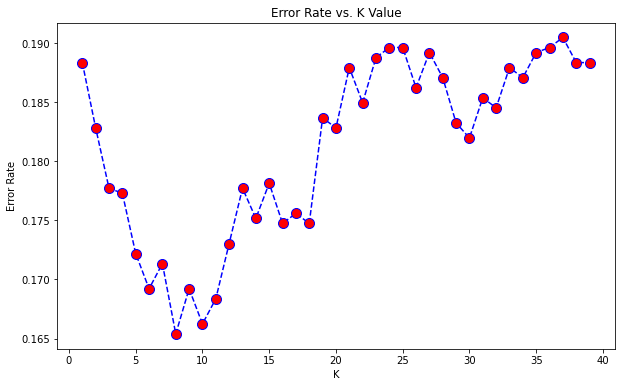

In [21]:
# plot the Error rate vs K Value graph
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

As we can see from the above graph that the difference between the error rate value is less hence at K=5 we get minimum error rate and high accuracy. It is same for K=5,6,7,8 therefore we choose the minimum k value.

In [24]:
# NOW WITH K=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=5


[[997 228]
 [177 950]]


              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1225
         1.0       0.81      0.84      0.82      1127

    accuracy                           0.83      2352
   macro avg       0.83      0.83      0.83      2352
weighted avg       0.83      0.83      0.83      2352



So the final accuracy that we are getting is 83% from our KNN model at K =5. 

<ipython-input-29-4490a8f1345b>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect("equal")


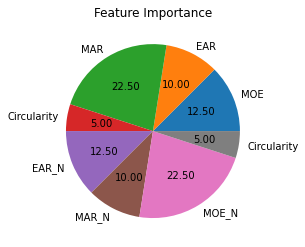

In [29]:
sizes = [25, 20, 45, 10, 25, 20, 45, 10]
labels = ["MOE", "EAR", "MAR", "Circularity", "EAR_N", "MAR_N", "MOE_N", "Circularity"]
plt.pie(sizes, labels = labels, autopct = "%.2f")
plt.title("Feature Importance")
plt.axes().set_aspect("equal")
plt.show()

## CNN

In [ ]:
# Reference: https://github.com/hackenjoe/Advanced_Drowsiness_Detection/blob/main/README.md

In [19]:
import pandas as pd
import glob
import numpy as np
import os.path
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

<h3><b>Function to Split Images into Train and Test Set </b></h3>

In [8]:
def copy_imgs(participants, train_set = True):
    x = [int(x) for x in participants]    
    alert_list, drowsy_list = [], []

    for i in x:
        
        alert_states = len(glob.glob("img/"+str(i)+"/p"+str(i)+"_s0*"))
        drowsy_states = len(glob.glob("img/"+str(i)+"/p"+str(i)+"_s10*"))

        MIN_T = 0 if train_set else int((alert_states*0.8))+1
        MAX_T = int((alert_states*0.8)) if train_set else alert_states
        for j in np.arange(MIN_T, MAX_T):
            alert_list.append(str(i)+"/p"+str(i)+"_s0_"+str(j)+"sec.jpg")

        MIN_T1 = 0 if train_set else int((drowsy_states*0.8))+1
        MAX_T1 = int((drowsy_states*0.8)) if train_set else drowsy_states
        for j in np.arange(MIN_T1, MAX_T1):
            drowsy_list.append(str(i)+"/p"+str(i)+"_s10_"+str(j)+"sec.jpg")
    
    for item in alert_list:
        if not (os.path.isfile(r'img/'+str(item))):
            print("Not found", item)
            continue
        if train_set:
            shutil.copy(r'img/'+str(item), r'/Users/manjinder/Desktop/dataset/training_data/0/')
        else:
            shutil.copy(r'img/'+str(item), r'/Users/manjinder/Desktop/dataset/testing_data/0/')
    
    for item in drowsy_list:
        if not (os.path.isfile(r'img/'+str(item))):
            print("Not found", item)
            continue
        if train_set:
            shutil.copy(r'img/'+str(item), r'/Users/manjinder/Desktop/dataset/training_data/1/')
        else:
            shutil.copy(r'img/'+str(item), r'/Users/manjinder/Desktop/dataset/testing_data/1/')

In [9]:
# We are using set for indexing each participant whose record we have fetched from data preprocessing
participants = set(pd.read_csv('Data/normalized_data.csv',sep=',').Participant)

In [10]:
copy_imgs(participants, train_set=True)
copy_imgs(participants, train_set=False)

Not found 43/p43_s0_0sec.jpg
Not found 3/p3_s10_0sec.jpg
Not found 5/p5_s10_0sec.jpg
Not found 10/p10_s10_0sec.jpg
Not found 16/p16_s10_0sec.jpg
Not found 18/p18_s10_0sec.jpg
Not found 19/p19_s10_0sec.jpg
Not found 22/p22_s10_0sec.jpg
Not found 28/p28_s10_0sec.jpg
Not found 44/p44_s10_0sec.jpg
Not found 48/p48_s10_0sec.jpg
Not found 53/p53_s10_0sec.jpg
Not found 57/p57_s10_0sec.jpg
Not found 60/p60_s10_0sec.jpg
Not found 50/p50_s0_241sec.jpg
Not found 50/p50_s0_242sec.jpg
Not found 50/p50_s0_243sec.jpg
Not found 50/p50_s0_244sec.jpg
Not found 50/p50_s0_245sec.jpg
Not found 50/p50_s0_246sec.jpg
Not found 50/p50_s0_247sec.jpg
Not found 50/p50_s0_248sec.jpg


In [11]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
transform_img = {'train': transforms.Compose([transforms.Resize((224,224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean.tolist(), std.tolist())]),
                 'unnormalize' : transforms.Normalize((-mean/std).tolist(),(1.0/std).tolist()),
                 'resize' : transforms.Compose([transforms.Resize((224,224)),
                                                transforms.ToTensor()])}

In [13]:
train_data = torchvision.datasets.ImageFolder(r"/Users/manjinder/Desktop/dataset/training_data",transform=transform_img["train"])

In [22]:
validation_data = torchvision.datasets.ImageFolder(r"/Users/manjinder/Desktop/dataset/testing_data", transform=transform_img["train"])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0) 
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False, num_workers=0)
print(train_data, validation_data)

traningimages, labels = next(iter(train_loader))
labels.shape

Dataset ImageFolder
    Number of datapoints: 9401
    Root location: /Users/manjinder/Desktop/dataset/training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.48500001430511475, 0.4560000002384186, 0.4059999883174896], std=[0.2290000021457672, 0.2240000069141388, 0.22499999403953552])
           ) Dataset ImageFolder
    Number of datapoints: 2331
    Root location: /Users/manjinder/Desktop/dataset/testing_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.48500001430511475, 0.4560000002384186, 0.4059999883174896], std=[0.2290000021457672, 0.2240000069141388, 0.22499999403953552])
           )


torch.Size([32])

<h3><b>Architecture of CNN</b></h3>

In [24]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(58320, 1024) 
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))     
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2_bn(self.conv2(x))), kernel_size=2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        return x

In [48]:
model = CNN()
print("Architecture of Convolutional Neural Network")
print(model)

Architecture of Convolutional Neural Network
CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=58320, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [34]:
num_epochs = 9
criterion = nn.CrossEntropyLoss() #log loss function
optimizer = torch.optim.SGD(model.parameters(), lr=10e-4, momentum=0.85)

In [35]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

In [43]:
train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
tb = SummaryWriter()

for epoch in range(0, num_epochs):
    train_loss, valid_loss, correct, correct_val = 0.0, 0.0, 0.0, 0.0

    # training-the-model
    model.train()
    for data, target in train_loader:
        data = data
        target = target
        optimizer.zero_grad()        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        train_loss += loss.item() * data.size(0)
                
    # collecting statistics for tb
    tb.add_scalar("Train Loss", train_loss, epoch)
    tb.add_scalar("Train Correct", correct, epoch)
    tb.add_scalar("Train Accuracy", correct / len(train_loader.sampler), epoch)
    tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
    tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
    tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
    tb.add_histogram("conv2.weight", model.conv2.weight, epoch)

    
    # validate-the-model
    model.eval()
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        correct_val += (predicted == target).sum().item()

        # collecting statistics for tb
        tb.add_scalar("Validation Loss", valid_loss, epoch)
        tb.add_scalar("Validation Correct", correct, epoch)
        tb.add_scalar("Validation Accuracy", correct_val / len(validation_loader.sampler), epoch)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    accuracy = 100 * correct / len(train_loader.sampler)
    accuracy_val = 100 * correct_val / len(validation_loader.sampler)
    #Appending accuracy and loss to their respective List declared in beginning
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(accuracy)
    valid_accuracies.append(accuracy_val)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Loss: {:.6f} 
          '\tValidation Accuracy: {:.6f}'.format(epoch, train_loss, accuracy, valid_loss, accuracy_val))



Epoch: 0 	Training Loss: 0.005073 	Accuracy: 99.925540 	Validation Loss: 0.000482 	Validation Accuracy: 100.000000
Epoch: 1 	Training Loss: 0.004909 	Accuracy: 99.882991 	Validation Loss: 0.000524 	Validation Accuracy: 100.000000
Epoch: 2 	Training Loss: 0.005317 	Accuracy: 99.893628 	Validation Loss: 0.000480 	Validation Accuracy: 100.000000
Epoch: 3 	Training Loss: 0.004340 	Accuracy: 99.914903 	Validation Loss: 0.000568 	Validation Accuracy: 100.000000
Epoch: 4 	Training Loss: 0.005476 	Accuracy: 99.882991 	Validation Loss: 0.000794 	Validation Accuracy: 100.000000
Epoch: 5 	Training Loss: 0.005046 	Accuracy: 99.893628 	Validation Loss: 0.000474 	Validation Accuracy: 100.000000
Epoch: 6 	Training Loss: 0.004880 	Accuracy: 99.882991 	Validation Loss: 0.000828 	Validation Accuracy: 100.000000
Epoch: 7 	Training Loss: 0.004193 	Accuracy: 99.914903 	Validation Loss: 0.000677 	Validation Accuracy: 100.000000
Epoch: 8 	Training Loss: 0.004954 	Accuracy: 99.872354 	Validation Loss: 0.00066

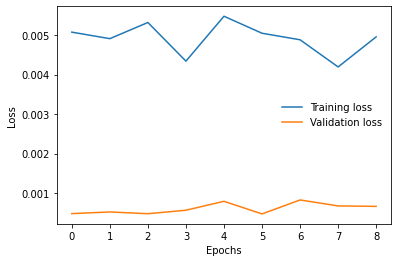

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

Validation images 
torch.Size([3, 224, 224])


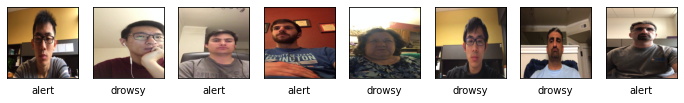

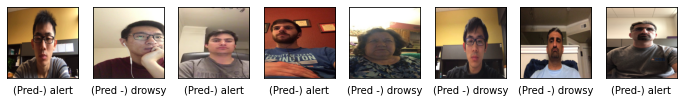

In [47]:
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=0)
validationimages, validationlabels = next(iter(validation_loader))
n = 8

fig, axes = plt.subplots(figsize=(12, 12), ncols=n)
print(f'Validation images \n{validationimages[0].size()}')

# actual labels
for i in range(n):
    axe1 = axes[i] 
    imshow(validationimages[i], validationlabels[i], ax=axe1, normalize=True)

# predicted labels
fig, axes = plt.subplots(figsize=(12, 12), ncols=n)
for i in range(n):
    axe1 = axes[i]
    image = validationimages[i].unsqueeze(0)
    model.eval()
    with torch.no_grad(): # deactivate autograd engine
        image = image
        output = torch.argmax(model(image), 1)
        
    # undo normalization for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    axe1.imshow(np.transpose(image.detach().cpu().numpy().squeeze(), (1, 2, 0)))
    axe1.spines['top'].set_visible(True)
    axe1.spines['right'].set_visible(True)
    axe1.spines['left'].set_visible(True)
    axe1.spines['bottom'].set_visible(True)
    axe1.tick_params(axis='both', length=0)
    axe1.set_xlabel("(Pred -) drowsy" if output.item()==1 else "(Pred-) alert")
    axe1.set_xticklabels('')
    axe1.set_yticklabels('')